In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

/home/mrigank/miniconda3/envs/fast/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
# build vocab of characters & integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 20
n_hidden = 200

batch_size = 32
max_steps = 200000

In [7]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/ 30**0.5 #0.15
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [8]:
lri = []
lossi = []

In [9]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3032
  10000/ 200000: 2.0484
  20000/ 200000: 2.8247
  30000/ 200000: 2.2985
  40000/ 200000: 2.1025
  50000/ 200000: 2.4764
  60000/ 200000: 2.6015
  70000/ 200000: 2.3140
  80000/ 200000: 1.9098
  90000/ 200000: 2.0857
 100000/ 200000: 1.7765
 110000/ 200000: 1.9925
 120000/ 200000: 1.9428
 130000/ 200000: 2.2242
 140000/ 200000: 2.1578
 150000/ 200000: 2.0473
 160000/ 200000: 2.4547
 170000/ 200000: 2.1142
 180000/ 200000: 1.6728
 190000/ 200000: 1.8863


In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0070888996124268
val 2.0923452377319336


## Issue with scaling manually all the W and b parameters - to ensure unit Gaussian nature throughout the network

- It's hard to decide scaling when it comes to networks with large number of layers.

---

# Precise setting of such scalings, is not that important: Due to some modern innovations.

1. Batch Norm (https://arxiv.org/pdf/1502.03167.pdf)
    - Idea was, if we wish to keep the activations throughout the network in **unit Gaussian** range
        - Why don't just **normalize** then with mean & std, which would maintain the desired distribution
2. 

In [11]:
# Mean of the activations over a batch: so a neuron will have a mean & std calculated across batch examples
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [12]:
hpreact.std(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [13]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/ 30**0.5 #0.15
# b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Scaling params for batch-norm
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# parameters = [C, W1, b1, W2, b2]
parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18367

In [14]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    
    ## -------------------------------------------------------------------------------------------
    ## Normalizing the hpreact, with it's mean & std
    ## This would not give good performance yet
    ## Coz, we want the activation firings to be roughly "unit Gaussian" at initialization
    ## But, DON'T want then to be forced Gaussian always
    
#     hpreact = embcat @ W1 + b1
#     hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)
    ## -------------------------------------------------------------------------------------------
    
    
    ## -------------------------------------------------------------------------------------------
    ## To handle not standardising (normalizing) always:
    ## Paper introduces an additional component - "Scaling & shifting"
        ## Take normalized inputs:
            ## normalize then with some GAIN
            ## offset with some BIAS
                ## Also, due to this, the b1 bias added below, would not serve any purpose
    
    hpreact = embcat @ W1 # + b1
    hpreact = (bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbias
    ## This above treatment to hpreact will make
    ## all neurons firing at unit Gaussian - at INITIALIZATION
        ## As bngain is 1s, bnbias is 0s
    ## And as optimization starts - they will start to adjust
    ## -------------------------------------------------------------------------------------------
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2924
  10000/ 200000: 2.2866
  20000/ 200000: 2.2139
  30000/ 200000: 2.1443
  40000/ 200000: 2.3116
  50000/ 200000: 1.9430
  60000/ 200000: 2.4954
  70000/ 200000: 2.3500
  80000/ 200000: 2.4079
  90000/ 200000: 2.3009
 100000/ 200000: 2.0993
 110000/ 200000: 1.9806
 120000/ 200000: 1.6657
 130000/ 200000: 1.9281
 140000/ 200000: 2.3242
 150000/ 200000: 2.4478
 160000/ 200000: 2.0123
 170000/ 200000: 2.4992
 180000/ 200000: 2.2298
 190000/ 200000: 2.1871


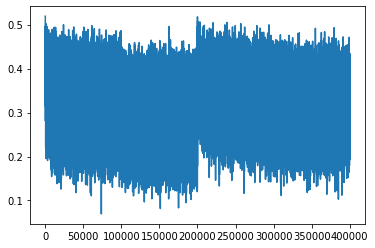

In [15]:
plt.plot(lossi)

In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    # h = torch.tanh(embcat @ W1 + b1)
    hpreact = embcat @ W1 # + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.044732093811035
val 2.0971972942352295


## We will not see any improvement in performance
- Coz, we are dealing with very small NN right now
- Also, we already had scaled W's decently, so **Batch Norm** does not have much to do here
---

## In future scenarios, where we'll have much larger networks - with Residual connections, CNNs etc, setting scales for all W matrices will become intractable
- And then we can see **Batch Norm** giving gains
- Then careful scaling of **W's** initialization would not be required
---

## Batch Norm has a COST attached to it
- Till now, an example was only depending on model parameters to produce its logits.
    - But with introduction of **Batch Norm** through a batch
        - A mathematical coupling of examples happens in forward & backward pass
- So, now the logits produced by an example is not only a function of its inputs & model params
    - But also, of other examples in the **batch**
- Suppose an example's **h** is going to jitter according to the samples that come into the batch with it

### It might seem like a BUG / UNDESIRABLE
### But it will turn out (as we'll see) as some kind of REGULARIZATION effect
- Also some kind of **data augmentation**

### This property of mathematical coupling b/w examples in a batch is still UNDESIRABLE
- So there exist other form of normalization methods, where normalizing across batch is not done
    - Layer Norm
    - Instance Norm
    - Group Norm
---

# ??? Problem: 
- How to we feed in single example during TEST to generate logits
- Coz, the network is now trained to calculate (mean, std) over a batch for **Batch Norm**

## Solution (proposed in paper):
- Fix and clamp a **bnmean** and **bnstd**
    Now we can pass a single test example to test the performance
- 2 ways to do it:
    1. After **training** completes, find a fix value for both and clamp them for testing purpose
    2. Instead calculate both in a **running** manner while training
        - On the side of training, **we calculate running mean & std of batch norm**

In [17]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/ 30**0.5 #0.15
# b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Scaling params for batch-norm
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden)) # Coz, initially hpreact will come out to be unit Gaussian, by the way of W init
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2]
parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18367

In [18]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        
        # mostly what it was earlier, just a small update in the direction of mean of batch
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        
        # mostly what it was earlier, just a small update in the direction of std of batch
        bnstd_running = 0.999 * bnstd_running + 0.0001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2924
  10000/ 200000: 2.2866
  20000/ 200000: 2.2139
  30000/ 200000: 2.1443
  40000/ 200000: 2.3116
  50000/ 200000: 1.9430
  60000/ 200000: 2.4954
  70000/ 200000: 2.3500
  80000/ 200000: 2.4079
  90000/ 200000: 2.3009
 100000/ 200000: 2.0993
 110000/ 200000: 1.9806
 120000/ 200000: 1.6657
 130000/ 200000: 1.9281
 140000/ 200000: 2.3242
 150000/ 200000: 2.4478
 160000/ 200000: 2.0123
 170000/ 200000: 2.4992
 180000/ 200000: 2.2298
 190000/ 200000: 2.1871


In [19]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    # h = torch.tanh(embcat @ W1 + b1)
    hpreact = embcat @ W1 # + b1
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.9740841388702393
val 3.0694797039031982
